# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [1]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 25.1 MB/s eta 0:00:

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Imports

In [36]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from darts import TimeSeries

%matplotlib inline

## 2. Load Dataset

In [37]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Sri_Lanka_Dengue_Cases_and_Weather_Data_updated.csv")

In [38]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Year,Month,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Avg Daylight Duration (hours)
0,Ampara,0,2007-01-01,2007,1,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,11.714583
1,Ampara,0,2007-01-08,2007,1,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,11.733333
2,Ampara,0,2007-01-15,2007,1,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,11.754167
3,Ampara,0,2007-01-22,2007,1,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,11.783333
4,Ampara,0,2007-01-29,2007,1,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,11.812500


In [39]:
len(df)

23250

In [40]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [41]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


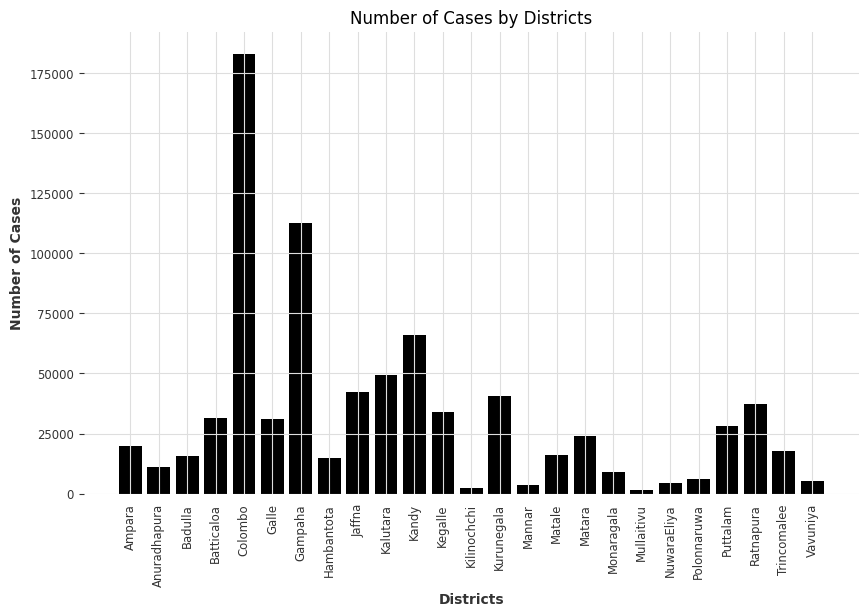

In [42]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/Models/Suraj_Karki_1_srilanka_dengue_outbreak_uni_variate_forecasting_using_classical_models/Number_of_Cases_by_Districts.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [43]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [44]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Year,Month,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Avg Daylight Duration (hours)
0,Ampara,0,2007-01-01,2007,1,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,11.714583
1,Ampara,0,2007-01-08,2007,1,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,11.733333
2,Ampara,0,2007-01-15,2007,1,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,11.754167
3,Ampara,0,2007-01-22,2007,1,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,11.783333
4,Ampara,0,2007-01-29,2007,1,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,11.812500


**The trend of cases of all 25 districts**

In [45]:
import plotly.express as px

# List of all districts
districts = df['District'].unique()

for district in districts:
    # Filter data for the current district
    df_district = df[df['District'] == district]

    # Create an interactive line plot using Plotly without markers
    fig = px.line(
        df_district,
        x="Week_End_Date",
        y="Number_of_Cases",
        title=f"Number of Cases Over Time - {district}",
        labels={'Week_End_Date': 'Week End Date', 'Number_of_Cases': 'Number of Cases'}
    )

    # Customize the layout for a bigger and clearer plot
    fig.update_layout(
        width=1000,  # Width of the figure
        height=600,  # Height of the figure
        title_font_size=18,
        xaxis_title_font_size=14,
        yaxis_title_font_size=14,
        hovermode="x"  # Show hover data for the x-axis
    )

    # Show the interactive plot with zoom and pan features
    fig.show()


## 5. Modelling
List of classical/statistical models.
- ARIMA
- AutoARIMA
- VARIMA
- ExponentialSmoothing
- FourTheta
- Prophet
- FFT
- KalmanForecaster

In [46]:
from darts.models import ARIMA, AutoARIMA, VARIMA, ExponentialSmoothing, FourTheta, Prophet, FFT, KalmanForecaster
from darts.metrics import rmse, mae, smape, r2_score, rmsle
import plotly.graph_objects as go

In [47]:
models = [ARIMA(), AutoARIMA(), ExponentialSmoothing(), Prophet(), FFT(), KalmanForecaster()]

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_forecast(train_series, val_series, model, district_name):
    model.fit(train_series)

    # Forecast for the next 12 weeks
    forecast = model.predict(n=len(val_series))

    # Calculate metrics
    val_values = val_series.values()
    forecast_values = forecast.values()

    # Ensure the forecast and validation values are the same length
    assert len(val_values) == len(forecast_values), "Forecast and validation series must have the same length for metrics calculation."

    # Compute metrics
    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series, forecast)
    error_smape = smape(val_series, forecast)
    error_rmsle = rmsle(val_series, forecast)

    errors = {
        "RMSE": error_rmse,
        "MAE": error_mae,
        "SMAPE": error_smape,
        "RMSLE": error_rmsle
    }
    results = [forecast, errors]
    return results


In [49]:
def main(data, models):
    districts = data['District'].unique()
    final_output = []
    for district in districts:
      # Filter data for the specified district
      district_data = data[data['District'] == district]

      # Ensure the 'Week_End_Date' column is in datetime format
      district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

      # Prepare the data
      series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases'])

      # Split series
      # Set aside the last 12 weeks as a validation series
      train_data, val_data = series[:-12], series[-12:]

      print(district)
      print(f"Training length: {len(train_data)}")
      print(f"Validation length: {len(val_data)}")
      district_output = []
      for m in models:
        print(f"Model: {m}")
        result = train_and_forecast(train_data, val_data, m, district)
        district_output.append(result)

      final_output.append(district_output)

    return final_output


In [50]:
results = main(df, models)

<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ampara
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/7fcas6vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/8syqtxve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17841', 'data', 'file=/tmp/tmp46ppjj5g/7fcas6vc.json', 'init=/tmp/tmp46ppjj5g/8syqtxve.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelzes4aiaz/prophet_model-20241230154737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Anuradhapura
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/asvq2oft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/0bd078ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41748', 'data', 'file=/tmp/tmp46ppjj5g/asvq2oft.json', 'init=/tmp/tmp46ppjj5g/0bd078ca.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelx60_rnwj/prophet_model-20241230154759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:47:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Badulla
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/_v59d92g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/gmmkwbyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36204', 'data', 'file=/tmp/tmp46ppjj5g/_v59d92g.json', 'init=/tmp/tmp46ppjj5g/gmmkwbyd.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_models6dyptfb/prophet_model-20241230154829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:29 - cmds

Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Batticaloa
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/w842py2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/z89di6cw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52477', 'data', 'file=/tmp/tmp46ppjj5g/w842py2t.json', 'init=/tmp/tmp46ppjj5g/z89di6cw.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modeltwoe425w/prophet_model-20241230154854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:48:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log



Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Colombo
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/fhul5w0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/ezdq4s0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18833', 'data', 'file=/tmp/tmp46ppjj5g/fhul5w0b.json', 'init=/tmp/tmp46ppjj5g/ezdq4s0d.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelwfeu3l8f/prophet_model-20241230154902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1

Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Galle
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/1zkfr64u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/ipmop2s7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23505', 'data', 'file=/tmp/tmp46ppjj5g/1zkfr64u.json', 'init=/tmp/tmp46ppjj5g/ipmop2s7.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelhbmc74k2/prophet_model-20241230154936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:49:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Gampaha
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/frinfsyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/tzsyiyyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79455', 'data', 'file=/tmp/tmp46ppjj5g/frinfsyn.json', 'init=/tmp/tmp46ppjj5g/tzsyiyyq.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_model_chp3yzc/prophet_model-20241230154948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Hambantota
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/4qzeua9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/f6_sodb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61680', 'data', 'file=/tmp/tmp46ppjj5g/4qzeua9k.json', 'init=/tmp/tmp46ppjj5g/f6_sodb5.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelca9_kic5/prophet_model-20241230154956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:49:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Jaffna
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/chqbitzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/yrr2epkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35634', 'data', 'file=/tmp/tmp46ppjj5g/chqbitzq.json', 'init=/tmp/tmp46ppjj5g/yrr2epkp.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modeliscbqniv/prophet_model-20241230155015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:50:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:50:15 - cmds

Model: Prophet()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log



Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kalutara
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/ouleumu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/pfivnvr7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41032', 'data', 'file=/tmp/tmp46ppjj5g/ouleumu4.json', 'init=/tmp/tmp46ppjj5g/pfivnvr7.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelvbm9pydl/prophet_model-20241230155047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:50:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:50:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kandy
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/rdq_bth8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/flm9jzh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3280', 'data', 'file=/tmp/tmp46ppjj5g/rdq_bth8.json', 'init=/tmp/tmp46ppjj5g/flm9jzh4.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modellul4zppe/prophet_model-20241230155103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kegalle
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/3l9xqwe1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/mnkiwxph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27318', 'data', 'file=/tmp/tmp46ppjj5g/3l9xqwe1.json', 'init=/tmp/tmp46ppjj5g/mnkiwxph.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelfn4qo8ax/prophet_model-20241230155208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kilinochchi
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/47mxoh51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/20n3vf2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47805', 'data', 'file=/tmp/tmp46ppjj5g/47mxoh51.json', 'init=/tmp/tmp46ppjj5g/20n3vf2o.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelvto2l9ek/prophet_model-20241230155239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kurunegala
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/5d85fq9c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/2cg6xtzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90019', 'data', 'file=/tmp/tmp46ppjj5g/5d85fq9c.json', 'init=/tmp/tmp46ppjj5g/2cg6xtzq.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modeldsnm69ny/prophet_model-20241230155259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:52:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Mannar
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/zgc17gpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/ukt444_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36939', 'data', 'file=/tmp/tmp46ppjj5g/zgc17gpa.json', 'init=/tmp/tmp46ppjj5g/ukt444_i.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_model8eoht90l/prophet_model-20241230155319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:2018: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:372: RuntimeWarning:

Mean of empty slice



Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Matale
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/yocyomex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/6cq0rstz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47917', 'data', 'file=/tmp/tmp46ppjj5g/yocyomex.json', 'init=/tmp/tmp46ppjj5g/6cq0rstz.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_model2dmac5rg/prophet_model-20241230155341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:41 - cmds

Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Matara
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/g3togkm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/ux3lgpgm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59055', 'data', 'file=/tmp/tmp46ppjj5g/g3togkm8.json', 'init=/tmp/tmp46ppjj5g/ux3lgpgm.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_models4cg2v7v/prophet_model-20241230155431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:54:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Monaragala
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/bc202l5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/phq_8t99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81098', 'data', 'file=/tmp/tmp46ppjj5g/bc202l5p.json', 'init=/tmp/tmp46ppjj5g/phq_8t99.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modeli_1ux65b/prophet_model-20241230155518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:55:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Mullaitivu
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/crnp8ssq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/fdg6qz6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58189', 'data', 'file=/tmp/tmp46ppjj5g/crnp8ssq.json', 'init=/tmp/tmp46ppjj5g/fdg6qz6r.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelqexgziwr/prophet_model-20241230155523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NuwaraEliya
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/ahpm9030.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/03uw0hrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48574', 'data', 'file=/tmp/tmp46ppjj5g/ahpm9030.json', 'init=/tmp/tmp46ppjj5g/03uw0hrw.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelgsgs97p6/prophet_model-20241230155542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Polonnaruwa
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/k2ie4wt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/rrz7c5ed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25028', 'data', 'file=/tmp/tmp46ppjj5g/k2ie4wt3.json', 'init=/tmp/tmp46ppjj5g/rrz7c5ed.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelv2zy7nj6/prophet_model-20241230155553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Puttalam
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/owgq1vqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/xmqvv2v1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83629', 'data', 'file=/tmp/tmp46ppjj5g/owgq1vqd.json', 'init=/tmp/tmp46ppjj5g/xmqvv2v1.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modeljukoa8kw/prophet_model-20241230155640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:40 - cmds

Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ratnapura
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/e7ftquw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/89uy_asf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52494', 'data', 'file=/tmp/tmp46ppjj5g/e7ftquw2.json', 'init=/tmp/tmp46ppjj5g/89uy_asf.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_model5licqaxh/prophet_model-20241230155711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model: Prophet()


15:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Trincomalee
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/nfsrjzhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/v4xdz36h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65147', 'data', 'file=/tmp/tmp46ppjj5g/nfsrjzhy.json', 'init=/tmp/tmp46ppjj5g/v4xdz36h.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelufx4w483/prophet_model-20241230155834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model: Prophet()
Model: FFT()
Model: KalmanForecaster()


<ipython-input-49-444c654a8de0>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Vavuniya
Training length: 918
Validation length: 12
Model: ARIMA()
Model: AutoARIMA()
Model: ExponentialSmoothing()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/f_wj473t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp46ppjj5g/_p593jy0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70947', 'data', 'file=/tmp/tmp46ppjj5g/f_wj473t.json', 'init=/tmp/tmp46ppjj5g/_p593jy0.json', 'output', 'file=/tmp/tmp46ppjj5g/prophet_modelx9gaxyb4/prophet_model-20241230155904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing


Model: Prophet()


INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:2018: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:372: RuntimeWarning:

Mean of empty slice



Model: FFT()
Model: KalmanForecaster()


## 6. Result

In [51]:
# Initialize a list to store metrics
metrics_list = []
districts = df['District'].unique()

# Iterate over results and extract metrics
for district_index, district_results in enumerate(results):
    for model_index, (forecast, metrics) in enumerate(district_results):
        metrics_list.append({
            'District': f'{districts[district_index]}',
            'Model': models[model_index],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'SMAPE': metrics['SMAPE'],
            'RMSLE': metrics['RMSLE']
        })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)
df_metrics.set_index(['District', 'Model'], inplace=True)

In [ ]:
from IPython.display import display
from IPython.display import HTML

def display_district_metrics(df_metrics):
    districts = df_metrics.index.get_level_values('District').unique()

    for district in districts:
        print(f"Metrics for {district}:")
        district_df = df_metrics.loc[district]
        styled_df = district_df.style \
         .highlight_min(color="lightgreen", axis=0)

        display(styled_df)

# Example usage
display_district_metrics(df_metrics)



Metrics for Ampara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.099221,2.459122,78.623317,0.884804
AutoARIMA(),2.908424,2.042721,77.538732,0.743101
ExponentialSmoothing(),4.389220,3.382198,158.554709,2.294345
Prophet(),14.809504,14.602118,149.042118,1.906945
FFT(),2.654085,2.103970,77.808794,0.751407
KalmanForecaster(),3.344411,2.163192,99.433750,0.804160


Metrics for Anuradhapura:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.418384,3.080280,51.596500,0.512084
AutoARIMA(),5.608356,5.346946,73.671715,0.745000
ExponentialSmoothing(),6.212020,5.608812,176.305306,1.839383
Prophet(),3.710987,3.219593,93.186584,0.810660
FFT(),11.608363,11.262490,106.804819,1.160866
KalmanForecaster(),2.674078,2.038442,37.823949,0.371907


Metrics for Badulla:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),5.284069,4.288914,41.877753,0.471284
AutoARIMA(),5.068367,4.274300,41.626900,0.463831
ExponentialSmoothing(),8.547257,7.591749,118.288145,1.303926
Prophet(),14.731524,14.341076,87.535174,0.969860
FFT(),7.224461,5.161763,54.749805,0.683889
KalmanForecaster(),4.995188,3.908931,40.961108,0.439653


Metrics for Batticaloa:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),8.923199,7.193104,48.215431,0.659904
AutoARIMA(),9.145959,7.367325,48.958059,0.669224
ExponentialSmoothing(),6.579610,5.487238,39.909279,0.507534
Prophet(),9.077204,8.360468,66.793103,0.674489
FFT(),29.881052,27.343535,200.000000,4.947312
KalmanForecaster(),4.587319,3.853970,30.030415,0.365819


Metrics for Colombo:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),78.792698,71.723585,29.850192,0.340098
AutoARIMA(),119.915537,111.932150,42.321865,0.472606
ExponentialSmoothing(),178.754312,160.865148,54.220598,0.631146
Prophet(),47.751729,38.901710,17.101802,0.213199
FFT(),140.627197,137.836395,104.956146,1.424164
KalmanForecaster(),46.319070,40.592077,17.940240,0.209584


Metrics for Galle:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),8.952799,6.637901,19.196369,0.242118
AutoARIMA(),8.224164,6.491608,18.713046,0.221353
ExponentialSmoothing(),31.512446,30.825018,170.127076,3.240767
Prophet(),24.902030,23.174581,51.609015,0.560426
FFT(),6.624702,6.095438,17.515767,0.181110
KalmanForecaster(),10.841586,8.585545,26.799912,0.314762


Metrics for Gampaha:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),50.975103,47.540147,36.211351,0.401854
AutoARIMA(),66.848368,63.116071,45.025786,0.495416
ExponentialSmoothing(),45.817301,41.743310,32.640411,0.368003
Prophet(),98.645098,97.267866,60.942263,0.641827
FFT(),45.304328,35.714245,35.347048,0.444124
KalmanForecaster(),16.963564,14.209452,12.807412,0.154914


Metrics for Hambantota:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.211103,2.148265,21.567694,0.273375
AutoARIMA(),3.014691,2.540846,25.636614,0.270268
ExponentialSmoothing(),11.900428,11.597929,198.967875,2.550648
Prophet(),5.299929,4.336221,38.342011,0.419134
FFT(),4.561347,4.331294,40.499847,0.408920
KalmanForecaster(),3.077573,1.956936,19.373024,0.257376


Metrics for Jaffna:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.367159,2.671718,29.369869,0.349778
AutoARIMA(),3.701615,3.028794,33.104155,0.356475
ExponentialSmoothing(),17.418161,15.715346,172.900879,0.389270
Prophet(),53.561193,53.078098,147.318377,1.864546
FFT(),13.176964,11.519039,104.747611,1.256537
KalmanForecaster(),5.960911,4.446707,53.034357,0.666451


Metrics for Kalutara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),10.685840,9.461975,22.767517,0.252856
AutoARIMA(),17.491704,15.424630,33.237399,0.384807
ExponentialSmoothing(),13.386879,11.034070,27.349064,0.321821
Prophet(),27.429608,26.036859,47.832681,0.513895
FFT(),11.059160,8.126247,19.557483,0.271006
KalmanForecaster(),13.291808,11.190015,28.285517,0.327109


Metrics for Kandy:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),15.082718,13.972008,19.513054,0.215031
AutoARIMA(),20.652458,18.892105,25.620886,0.285308
ExponentialSmoothing(),16.304375,11.520316,15.781976,0.213083
Prophet(),74.124897,73.199765,69.588397,0.740493
FFT(),13.491686,10.984387,14.766048,0.171065
KalmanForecaster(),10.433591,9.490824,13.164583,0.141632


Metrics for Kegalle:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),11.697278,10.101424,39.667015,0.470168
AutoARIMA(),10.243956,9.012164,36.560803,0.422713
ExponentialSmoothing(),20.373008,19.462760,154.663406,2.548383
Prophet(),38.813883,37.908072,91.847386,0.994242
FFT(),9.949235,8.132548,38.790884,0.433024
KalmanForecaster(),4.748556,3.589744,15.559609,0.187163


Metrics for Kilinochchi:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),2.496670,2.254237,128.371808,1.066119
AutoARIMA(),2.922382,2.640826,131.195529,1.156530
ExponentialSmoothing(),1.468641,1.283583,118.662274,0.762214
Prophet(),2.274515,1.991701,122.226394,1.015702
FFT(),1.507078,1.256277,114.094500,0.790798
KalmanForecaster(),1.477381,1.257309,114.966804,0.780126


Metrics for Kurunegala:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),18.045136,16.423398,61.782636,0.766273
AutoARIMA(),17.029075,15.320417,59.164192,0.740868
ExponentialSmoothing(),13.276622,11.258101,70.634116,0.831368
Prophet(),27.300544,25.280223,78.399933,0.911426
FFT(),10.104415,8.402775,39.753638,0.544864
KalmanForecaster(),8.893488,7.222919,35.283315,0.495440


Metrics for Mannar:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),4.362453,3.952914,71.060861,0.730224
AutoARIMA(),4.358855,3.881062,71.519665,0.693590
ExponentialSmoothing(),5.331115,4.204450,80.939238,0.795922
Prophet(),4.580701,3.531803,64.872236,0.694451
FFT(),9.966846,9.031561,200.000000,nan
KalmanForecaster(),5.167076,3.943767,75.571123,0.775847


Metrics for Matale:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),13.238632,8.843256,47.254865,0.608026
AutoARIMA(),12.444922,7.527396,36.453312,0.533279
ExponentialSmoothing(),20.298754,17.212922,152.960581,2.183064
Prophet(),11.306673,8.947363,43.242172,0.532335
FFT(),11.029633,9.227730,46.956335,0.500589
KalmanForecaster(),14.549845,9.942823,57.658086,0.761425


Metrics for Matara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),9.589574,7.749112,33.845210,0.410429
AutoARIMA(),8.406650,6.582804,29.018048,0.385423
ExponentialSmoothing(),16.757942,14.566599,80.457577,0.885664
Prophet(),14.754121,12.349964,56.036206,0.663395
FFT(),10.396866,8.375388,35.032040,0.473193
KalmanForecaster(),12.315422,9.522198,43.555364,0.541310


Metrics for Monaragala:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),13.938229,10.521366,66.733751,0.783134
AutoARIMA(),13.671821,10.100387,62.235793,0.750526
ExponentialSmoothing(),17.881109,15.134579,133.498099,1.532364
Prophet(),10.525431,8.134065,47.243666,0.595303
FFT(),11.778884,8.901833,52.939360,0.629054
KalmanForecaster(),15.634008,12.059669,82.101791,0.988078


Metrics for Mullaitivu:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),1.063524,0.834671,91.795825,0.530969
AutoARIMA(),1.040757,0.832854,92.112929,0.522757
ExponentialSmoothing(),1.385525,1.042763,154.490454,0.677249
Prophet(),2.320249,2.009647,111.342869,0.955399
FFT(),1.454997,1.207056,96.851146,0.700527
KalmanForecaster(),1.112963,0.866237,111.870271,0.511549


Metrics for NuwaraEliya:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),2.500741,1.729244,54.334047,0.599123
AutoARIMA(),2.355143,1.715307,55.030864,0.555474
ExponentialSmoothing(),4.533962,4.270916,187.696981,2.160362
Prophet(),1.726454,1.461493,55.442095,0.496186
FFT(),2.862279,2.284175,57.729835,0.687527
KalmanForecaster(),2.589690,2.089324,76.408959,0.616119


Metrics for Polonnaruwa:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),3.539863,3.262721,58.452800,0.578770
AutoARIMA(),3.485473,3.191543,57.542121,0.571212
ExponentialSmoothing(),3.489477,2.818883,52.510993,0.496961
Prophet(),3.406342,3.197836,57.947929,0.556641
FFT(),3.605953,2.756666,51.264824,0.513666
KalmanForecaster(),3.278998,2.872400,53.283808,0.505114


Metrics for Puttalam:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),6.045021,4.489592,26.338818,0.315311
AutoARIMA(),5.549774,4.780151,28.255235,0.306565
ExponentialSmoothing(),24.540971,23.236285,179.623927,1.486090
Prophet(),32.032052,31.497585,98.108994,1.081652
FFT(),10.311994,8.867293,65.066909,0.694014
KalmanForecaster(),7.695629,5.586956,34.215863,0.437937


Metrics for Ratnapura:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),20.150341,18.234628,36.029226,0.415576
AutoARIMA(),11.782504,10.038148,22.129269,0.259250
ExponentialSmoothing(),22.403571,19.014165,48.696581,0.577872
Prophet(),20.581417,17.607311,32.821546,0.396417
FFT(),14.061650,12.228517,30.401687,0.358347
KalmanForecaster(),20.563726,17.231579,44.544843,0.556269


Metrics for Trincomalee:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),10.344736,9.915396,113.475562,1.290085
AutoARIMA(),16.750282,15.791271,130.021849,1.621114
ExponentialSmoothing(),6.202481,5.646806,89.420599,0.976276
Prophet(),3.470175,3.131225,65.833983,0.671520
FFT(),9.936098,8.555623,118.687908,1.383777
KalmanForecaster(),4.315433,3.411745,66.342681,0.750522


Metrics for Vavuniya:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
ARIMA(),1.929947,1.768483,158.650941,0.907844
AutoARIMA(),4.300483,3.887668,151.051668,1.497524
ExponentialSmoothing(),2.656300,2.378009,149.932885,1.140133
Prophet(),3.638928,3.087540,200.000000,nan
FFT(),4.794914,4.145484,147.795437,1.548288
KalmanForecaster(),1.325376,1.019989,157.280487,0.545903


## 7. Conclusion
To assess each models we need to see the error metrics of each model and then we have to decide which model outperformed.

Note: `We also need to do backtesting to make sure model is performing as intended`